In [16]:
# Install these packages if you haven't already!

# pip install pandas
# pip install scikit-learn
# pip install joblib
# pip install numpy
# pip install xgboost
# pip install matplotlib
# pip install seaborn

# __author__    = "Siem Vonk"
# __studentID__ = "i6290798"

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import joblib

import os
print(os.getcwd())

c:\Users\vonks\OneDrive\Documents\! Code\Course 5 ML\MSc_ML_Assignment


## Importing New Data

In [17]:
# Input new data here:
data_new = pd.read_csv("test_set.csv")
#data_new = pd.read_csv("data_regression_test_df.csv")

# Keep only the columns in the list in the same order (these had too many missing for training)
with open("files/columns_to_keep.txt") as f:
    columns_to_keep = [line.strip() for line in f]
data_new = data_new[columns_to_keep]

X_new = data_new.drop(columns=['Viability'])
y_new = data_new['Viability']

# Load trained preprocessing models
imputer = joblib.load("files/imputer.pkl")
encoder = joblib.load("files/encoder.pkl")
scaler = joblib.load("files/scaler.pkl")
feature_order = joblib.load("files/feature_order.pkl")

# Impute missing values
X_new_imputed = pd.DataFrame(
    imputer.transform(X_new),
    columns=X_new.columns,
    index=X_new.index
)

# Encode categorical variables
categorical_cols = X_new.select_dtypes(include='object').columns
X_new_encoded = pd.DataFrame(
    encoder.transform(X_new_imputed[categorical_cols]),
    columns=encoder.get_feature_names_out(categorical_cols),
    index=X_new.index
)

# Combine categorical with numeric features
numeric_cols = X_new_imputed.select_dtypes(include=[np.number]).columns
X_new_final = pd.concat([X_new_imputed[numeric_cols], X_new_encoded], axis=1)

# Align columns to match training
for col in feature_order:
    if col not in X_new_final.columns:
        X_new_final[col] = 0
X_new_final = X_new_final[feature_order]

# Scale features
X_new_scaled = scaler.transform(X_new_final) # Forgetting this line caused me a lot of pain debugging
X_new_scaled_df = pd.DataFrame(X_new_scaled, columns=X_new_final.columns, index=X_new_final.index)

In [18]:
# Load model results (Saved = No are not saved due to low performance and better alternatives)
model_results = pd.read_csv("files/model_results.csv")
print(model_results)

             Model         MSE  R² Score Saved
0   Ensemble Stack  442.548698  0.579968   Yes
1               RF  442.731225  0.579794   Yes
2      RF(default)  471.539635  0.552452    No
3     Ensemble AVG  503.884639  0.521752    No
4              MLP  640.089711  0.392477   Yes
5              KNN  640.592226  0.392000   Yes
6          XGBoost  702.640506  0.333109   Yes
7            Lasso  783.391590  0.256466   Yes
8      Elastic Net  783.441468  0.256419    No
9            Ridge  784.210216  0.255689    No
10             SVR  972.290282  0.077179    No


In [19]:
# Random Forest Regression (DEFAULT)
rf_model = joblib.load("files/random_forest_default.pkl")
y_pred_rf_default = rf_model.predict(X_new_scaled_df)
mse_rf_default = mean_squared_error(y_new, y_pred_rf_default)
r2_rf_default = r2_score(y_new, y_pred_rf_default)

print("Random Forest Regression Results (default)")
print(f"Mean Squared Error (MSE): {mse_rf_default:.4f}")
print(f"R² Score: {r2_rf_default:.4f}")

Random Forest Regression Results (default)
Mean Squared Error (MSE): 471.5396
R² Score: 0.5525


In [20]:
# Random Forest Regression Optimized
rf_model = joblib.load("files/random_forest.pkl")
y_pred_rf = rf_model.predict(X_new_scaled_df)
mse_rf = mean_squared_error(y_new, y_pred_rf)
r2_rf = r2_score(y_new, y_pred_rf)

print("Random Forest Regression Results")
print(f"Mean Squared Error (MSE): {mse_rf:.4f}")
print(f"R² Score: {r2_rf:.4f}")


Random Forest Regression Results
Mean Squared Error (MSE): 442.7312
R² Score: 0.5798


In [21]:
# Ensemble Stack (RF, KNN, MLP)
stack = joblib.load("files/stack.pkl")
stack_preds = stack.predict(X_new_scaled_df)
mse_stack = mean_squared_error(y_new, stack_preds)
r2_stack = r2_score(y_new, stack_preds)

print("Stacking Regressor Results")
print(f"MSE: {mse_stack:.4f}")
print(f"R² Score: {r2_stack:.4f}")


Stacking Regressor Results
MSE: 442.5487
R² Score: 0.5800


In [22]:
# KNN
knn = joblib.load("files/knn.pkl")
knn_preds = knn.predict(X_new_scaled_df)
mse_knn = mean_squared_error(y_new, knn_preds)
r2_knn = r2_score(y_new, knn_preds)

print("KNN Results")
print(f"MSE: {mse_knn:.2f}")
print(f"R² Score: {r2_knn:.2f}")

KNN Results
MSE: 640.59
R² Score: 0.39


In [23]:
# MLP (Neural Network)
mlp = joblib.load("files/mlp.pkl")
mlp_preds = mlp.predict(X_new_scaled_df)
mse_mlp = mean_squared_error(y_new, mlp_preds)
r2_mlp = r2_score(y_new, mlp_preds)

print("MLP Results")
print(f"MSE: {mse_mlp:.2f}")
print(f"R² Score: {r2_mlp:.2f}")

MLP Results
MSE: 640.09
R² Score: 0.39


In [24]:
# LASSO (L1 Regularization)
lasso = joblib.load("files/lasso.pkl")
lasso_preds = lasso.predict(X_new_scaled_df)
mse_lasso = mean_squared_error(y_new, lasso_preds)
r2_lasso = r2_score(y_new, lasso_preds)

print("LASSO Results")
print(f"MSE: {mse_lasso:.2f}")
print(f"R² Score: {r2_lasso:.2f}")

LASSO Results
MSE: 783.39
R² Score: 0.26


## Figures

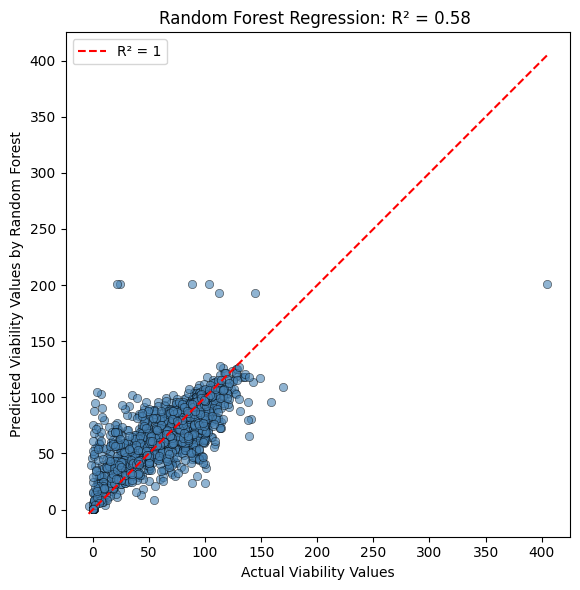

In [25]:
# y_test vs y_pred_rf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_new, y=y_pred_rf, color="steelblue", alpha=0.6, edgecolor='k')

# Plot y = x line for reference
max_val = max(max(y_new), max(y_pred_rf))
min_val = min(min(y_new), min(y_pred_rf))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='R² = 1')

# Labels and title
plt.xlabel("Actual Viability Values")
plt.ylabel("Predicted Viability Values by Random Forest")
plt.title(f"Random Forest Regression: R² = {r2_rf:.2f} ")
plt.legend()
# Set 1:1 aspect ratio
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()


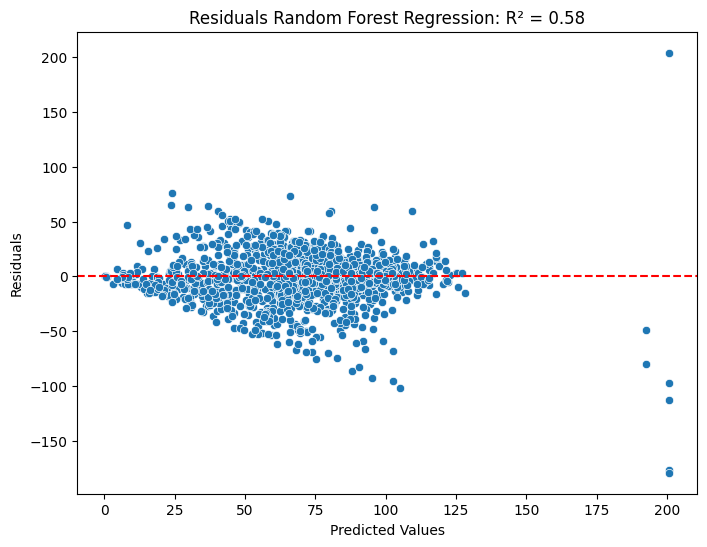

In [26]:
# Residuals plot for Random Forest

residuals = y_new - y_pred_rf
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_rf, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title(f'Residuals Random Forest Regression: R² = {r2_rf:.2f}')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


Top 10 Feature Importances:
Dose_microg_mL           0.157596
core_size_nm             0.145883
Duration_h               0.078924
NP_type_Ag               0.033921
NP_type_ZnO              0.028773
cell_Organ_BoneMarrow    0.022332
NP_type_MWCNT            0.020844
NP_type_CdTe             0.019134
NP_type_SLN              0.018888
NP_type_CuO              0.014804
dtype: float64


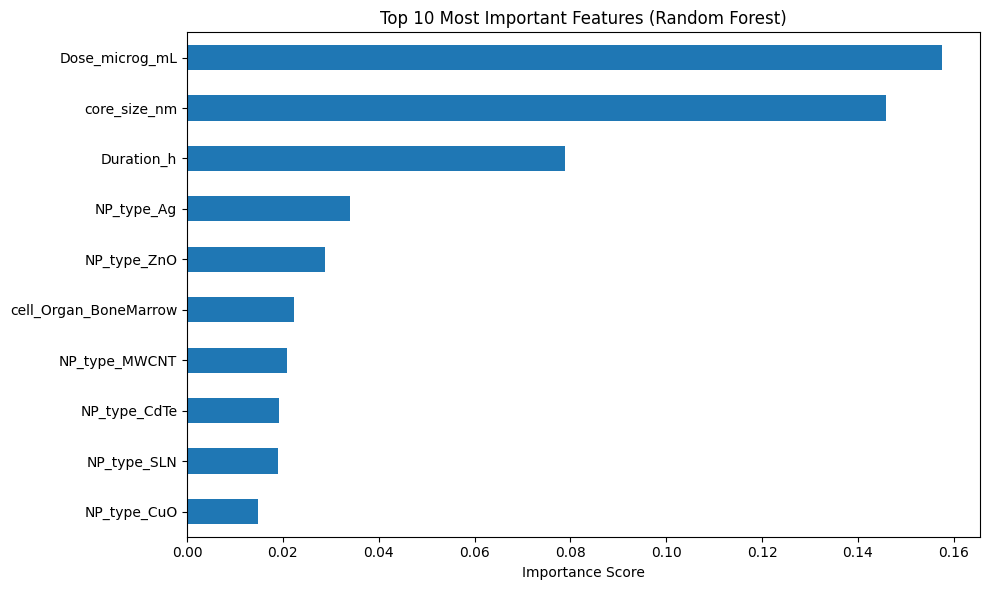

In [27]:
# Random Forest feature importance
import pandas as pd
import matplotlib.pyplot as plt

importances = pd.Series(rf_model.feature_importances_, index=X_new_scaled_df.columns)
top_importances = importances.sort_values(ascending=False).head(10)

print("Top 10 Feature Importances:")
print(top_importances)

plt.figure(figsize=(10, 6))
top_importances.plot(kind='barh')
plt.gca().invert_yaxis()  # Most important on top
plt.title("Top 10 Most Important Features (Random Forest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

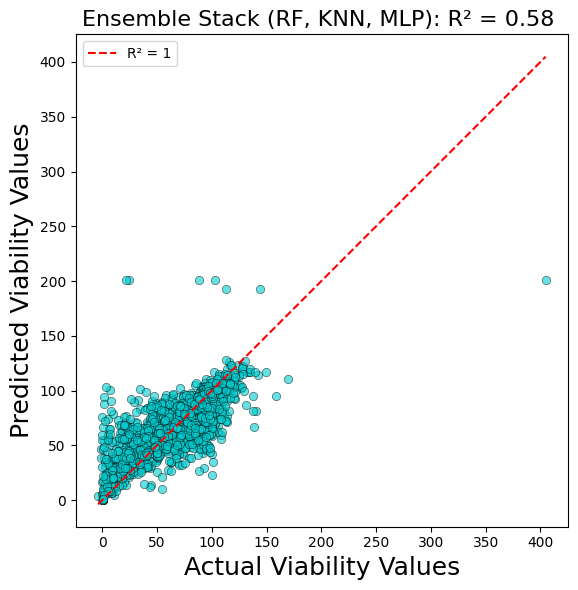

In [37]:
# Plot the stack predictions vs y_test
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_new, y=stack_preds, color="darkturquoise", alpha=0.6, edgecolor='k')

# Plot y = x line for reference
max_val = max(max(y_new), max(stack_preds))
min_val = min(min(y_new), min(stack_preds))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='R² = 1')

# Labels and title
plt.xlabel("Actual Viability Values", fontsize = 18)
plt.ylabel("Predicted Viability Values", fontsize = 18)
plt.title(f"Ensemble Stack (RF, KNN, MLP): R² = {r2_stack:.2f} ", fontsize = 16)
plt.legend()
# Set 1:1 aspect ratio
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()


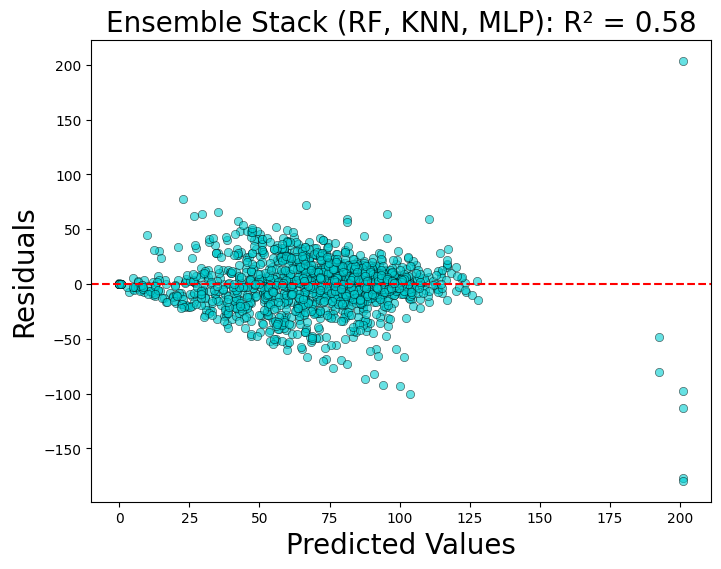

In [31]:
# Residuals plot for Stack

residuals = y_new - stack_preds
plt.figure(figsize=(8, 6))
sns.scatterplot(x=stack_preds, y=residuals, color="darkturquoise", alpha=0.6, edgecolor='k')
plt.axhline(0, color='red', linestyle='--')
plt.title(f'Ensemble Stack (RF, KNN, MLP): R² = {r2_stack:.2f}', fontsize = 20)
plt.xlabel('Predicted Values', fontsize = 20)
plt.ylabel('Residuals', fontsize = 20)
plt.show()
